# Multi-Layer Perceptron (MLP) for Heart Disease Prediction
This notebook builds and evaluates a Multi-Layer Perceptron (MLP) classifier on the heart disease dataset. It follows the same structure and style as the previous notebooks, with clear code, visualizations, and markdown explanations.

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['teal', 'crimson'])
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Load data
data = pd.read_csv('../data/heart_featured.csv')
cat_cols = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope', 'LawChol', 'LawOldpeak']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target_col = 'HeartDisease'

## Data Splitting and Preprocessing
MLPs require all features to be numeric and scaled. We'll use one-hot encoding for categoricals and standard scaling for numericals.

In [3]:
# Split data
y = data[target_col]
X = data.drop(columns=[target_col])
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

## MLP Model Training and Hyperparameter Tuning (PyTorch)
We'll use PyTorch to build and train the MLP. We'll use early stopping and validation monitoring.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_prep, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_prep, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_prep, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train_prep.shape[1]
model = MLP(input_dim)

# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping
best_val_loss = float('inf')
patience = 10
counter = 0
num_epochs = 100
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = criterion(val_preds, y_val_tensor).item()
        val_losses.append(val_loss)
    print(f'Epoch {epoch+1}: train loss={train_loss:.4f}, val loss={val_loss:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping!')
            break
# Load best model
model.load_state_dict(best_model_state)

Epoch 1: train loss=0.6564, val loss=0.6252
Epoch 2: train loss=0.5829, val loss=0.5419
Epoch 3: train loss=0.4909, val loss=0.4589
Epoch 4: train loss=0.4187, val loss=0.4147
Epoch 5: train loss=0.3865, val loss=0.4010
Epoch 6: train loss=0.3724, val loss=0.3903
Epoch 7: train loss=0.3653, val loss=0.3814
Epoch 8: train loss=0.3480, val loss=0.3715
Epoch 9: train loss=0.3304, val loss=0.3669
Epoch 10: train loss=0.3302, val loss=0.3619
Epoch 11: train loss=0.3259, val loss=0.3598
Epoch 12: train loss=0.3315, val loss=0.3615
Epoch 13: train loss=0.3236, val loss=0.3587
Epoch 14: train loss=0.3269, val loss=0.3543
Epoch 15: train loss=0.3194, val loss=0.3512
Epoch 16: train loss=0.3168, val loss=0.3481
Epoch 17: train loss=0.3141, val loss=0.3482
Epoch 18: train loss=0.3068, val loss=0.3443
Epoch 19: train loss=0.3134, val loss=0.3436
Epoch 20: train loss=0.3062, val loss=0.3426
Epoch 21: train loss=0.2971, val loss=0.3452
Epoch 22: train loss=0.3023, val loss=0.3405
Epoch 23: train los

<All keys matched successfully>

Validation Accuracy: 0.8695652173913043
Classification Report:               precision    recall  f1-score   support

           0       0.87      0.84      0.85        62
           1       0.87      0.89      0.88        76

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138

Confusion Matrix: [[52 10]
 [ 8 68]]


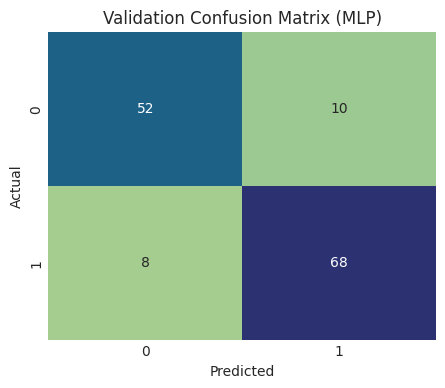

In [5]:
# Validation set evaluation
model.eval()
with torch.no_grad():
    val_probs = model(X_val_tensor).cpu().numpy().flatten()
    val_preds = (val_probs > 0.5).astype(int)
print('Validation Accuracy:', accuracy_score(y_val, val_preds))
print('Classification Report:', classification_report(y_val, val_preds))
print('Confusion Matrix:', confusion_matrix(y_val, val_preds))

# Visualize confusion matrix
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix (MLP)')
plt.show()

Test Accuracy: 0.8985507246376812
Classification Report:               precision    recall  f1-score   support

           0       0.90      0.87      0.89        62
           1       0.90      0.92      0.91        76

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138

Confusion Matrix: [[54  8]
 [ 6 70]]


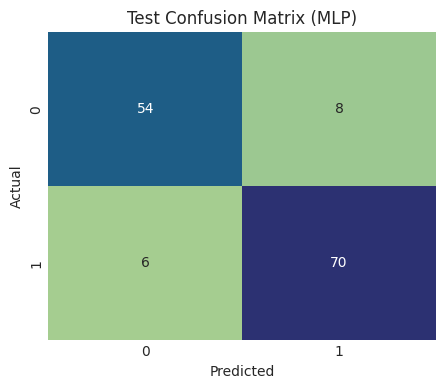

In [6]:
# Test set evaluation for MLP
model.eval()
with torch.no_grad():
    test_probs = model(X_test_tensor).cpu().numpy().flatten()
    test_preds = (test_probs > 0.5).astype(int)
print('Test Accuracy:', accuracy_score(y_test, test_preds))
print('Classification Report:', classification_report(y_test, test_preds))
print('Confusion Matrix:', confusion_matrix(y_test, test_preds))

# Visualize confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix (MLP)')
plt.show()

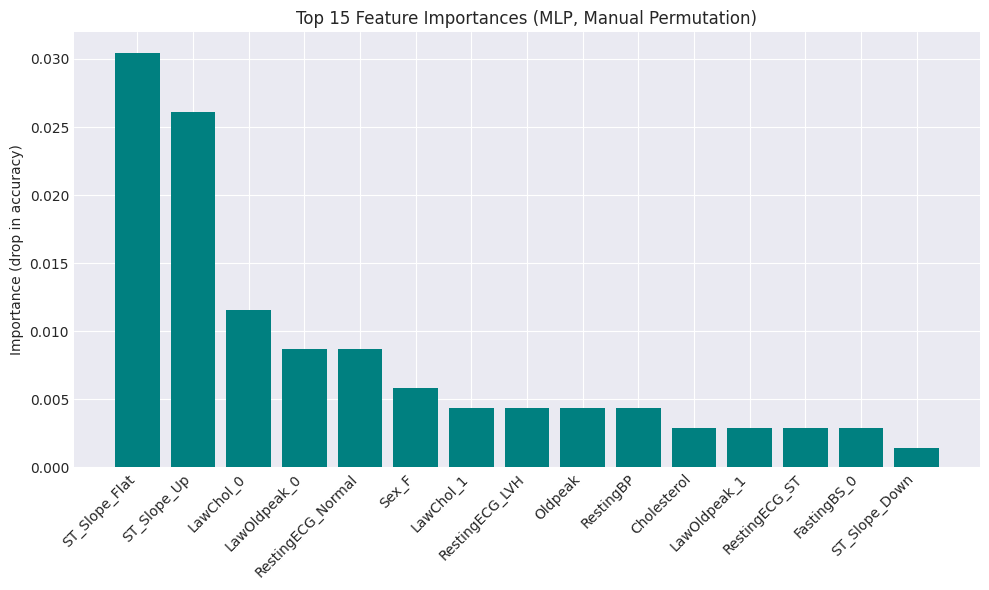

1. ST_Slope_Flat: 0.0304
2. ST_Slope_Up: 0.0261
3. LawChol_0: 0.0116
4. LawOldpeak_0: 0.0087
5. RestingECG_Normal: 0.0087
6. Sex_F: 0.0058
7. LawChol_1: 0.0043
8. RestingECG_LVH: 0.0043
9. Oldpeak: 0.0043
10. RestingBP: 0.0043
11. Cholesterol: 0.0029
12. LawOldpeak_1: 0.0029
13. RestingECG_ST: 0.0029
14. FastingBS_0: 0.0029
15. ST_Slope_Down: 0.0014
16. ChestPainType_ATA: 0.0014
17. ChestPainType_TA: 0.0000
18. ChestPainType_NAP: -0.0000
19. Sex_M: -0.0014
20. MaxHR: -0.0014
21. ChestPainType_ASY: -0.0029
22. FastingBS_1: -0.0043
23. ExerciseAngina_Y: -0.0072
24. ExerciseAngina_N: -0.0072
25. Age: -0.0087


In [9]:
# Manual permutation feature importance for MLP
import copy

def compute_permutation_importance(model, X, y, n_repeats=5):
    baseline_acc = accuracy_score(y, (model(torch.tensor(X, dtype=torch.float32)).detach().cpu().numpy().flatten() > 0.5).astype(int))
    importances = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = copy.deepcopy(X)
            np.random.shuffle(X_permuted[:, i])
            acc = accuracy_score(y, (model(torch.tensor(X_permuted, dtype=torch.float32)).detach().cpu().numpy().flatten() > 0.5).astype(int))
            scores.append(baseline_acc - acc)
        importances[i] = np.mean(scores)
    return importances

importances = compute_permutation_importance(model, X_val_prep, y_val.values, n_repeats=5)
indices = np.argsort(importances)[::-1]
feature_names = (
    list(preprocessor.named_transformers_['num'].get_feature_names_out(num_cols)) +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
)

plt.figure(figsize=(10, 6))
plt.title('Top 15 Feature Importances (MLP, Manual Permutation)')
plt.bar(range(15), importances[indices][:15], align='center', color='teal')
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=45, ha='right')
plt.ylabel('Importance (drop in accuracy)')
plt.tight_layout()
plt.show()

# Print top 25 features
for i in range(25):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

In [10]:
# Save MLP model performance and feature importances to CSV
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
perf_rows = []
for split, X_, y_, preds in [
    ('validation', X_val_prep, y_val, val_preds),
    ('test', X_test_prep, y_test, test_preds),
    ]:
    perf_rows.append({
        'model': 'MLP',
        'split': split,
        'accuracy': accuracy_score(y_, preds),
        'precision': precision_score(y_, preds),
        'recall': recall_score(y_, preds),
        'f1': f1_score(y_, preds)
    })
perf_df = pd.DataFrame(perf_rows)
perf_df.to_csv('../data/model_performance.csv', mode='a', header=False, index=False)

# Save top 25 permutation importances
fi_df = pd.DataFrame({
    'model': 'MLP',
    'feature': [feature_names[i] for i in indices[:25]],
    'importance': importances[indices[:25]]
})
fi_df.to_csv('../data/feature_importance.csv', mode='a', header=False, index=False)